In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/wolf_5.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/phone_7.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/monkey_4.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/bus_10.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/animal_painting_8.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/fox_2.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/mouse_6.png
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/drink_7.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/animal_statue_8.jpg
/kaggle/input/animal-classification-dataset/Animal_Classification/dataset/Unknown/animal_painting_4.jpg
/kaggle/input/animal-classification

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

2025-10-14 04:03:38.426184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760414618.676781      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760414618.748109      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.utils import shuffle

# ---------------------------
# Configuration
# ---------------------------
images_per_class = 500
target_size = (224, 224)
save_root = '/kaggle/working/stable_augmented'
os.makedirs(save_root, exist_ok=True)

# ---------------------------
# Augmentation Functions
# ---------------------------
def zoom_image(img_array, zoom_factor=0.9):
    h, w, _ = img_array.shape
    cropped = tf.image.central_crop(img_array, central_fraction=zoom_factor)
    resized = tf.image.resize(cropped, (h, w))
    return resized

def shear_image(img_array, shear_level=0.2):
    h, w, _ = img_array.shape
    transform = [1.0, shear_level, 0.0,
                 0.0, 1.0, 0.0,
                 0.0, 0.0]
    transform = tf.convert_to_tensor([transform], dtype=tf.float32)
    img_array = tf.expand_dims(img_array, 0)
    sheared = tf.raw_ops.ImageProjectiveTransformV3(
        images=img_array,
        transforms=transform,
        output_shape=[h, w],
        interpolation="BILINEAR",
        fill_value=0.0
    )
    return tf.squeeze(sheared, 0)

def rotate_image(img_array, k=1):
    return tf.image.rot90(img_array, k=k)

# ---------------------------
# Process Class Images
# ---------------------------
def process_class_images(class_name, class_paths, augmentations, total_images=None):
    """Augment images for each class."""
    augmented_images = []
    n_orig = len(class_paths)
    idx = 0

    if total_images:  # for known classes
        n_needed = total_images - n_orig
        while len(augmented_images) < n_needed:
            img_path = class_paths[idx % n_orig]
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0

            for aug_func in augmentations:
                if len(augmented_images) >= n_needed:
                    break
                aug_img = aug_func(img_array)
                augmented_images.append(aug_img)
            idx += 1

        # Include original images
        original_images = [img_to_array(load_img(p, target_size=target_size))/255.0 for p in class_paths]
        all_images = original_images + augmented_images
    else:  # for unknown class
        all_images = []
        for img_path in class_paths:
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0
            aug_img = tf.image.flip_left_right(img_array)  # only one augmentation
            all_images.extend([img_array, aug_img])

    return all_images

# ---------------------------
# Main Loop Over Classes
# ---------------------------
root_path = '/kaggle/input/animal-classification-dataset/Animal_Classification/dataset'
class_names = sorted(os.listdir(root_path))

for class_id, class_name in enumerate(class_names):
    print(f"Processing class: {class_name}")
    class_folder = os.path.join(root_path, class_name)
    class_paths = [os.path.join(class_folder, f) for f in os.listdir(class_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    save_class_folder = os.path.join(save_root, class_name)
    os.makedirs(save_class_folder, exist_ok=True)

    if class_name.lower() == 'unknown':
        aug_images = process_class_images(
            class_name,
            class_paths,
            augmentations=[],  # single augment rule inside
            total_images=None
        )
    else:
        aug_images = process_class_images(
            class_name,
            class_paths,
            augmentations=[
                tf.image.flip_left_right,
                tf.image.flip_up_down,
                lambda x: rotate_image(x, k=1),
                lambda x: rotate_image(x, k=2),
                lambda x: zoom_image(x),
                lambda x: shear_image(x)
            ],
            total_images=images_per_class
        )

    # Save images
    for idx, img_array in enumerate(aug_images):
        img_pil = array_to_img(img_array)
        img_pil.save(os.path.join(save_class_folder, f"{class_name}_{idx}.jpg"))

print(f"✅ All classes processed and saved to: {save_root}")


Processing class: Bear


I0000 00:00:1760414641.765512      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760414641.766278      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Processing class: Bird
Processing class: Cat
Processing class: Cow
Processing class: Deer
Processing class: Dog
Processing class: Dolphin
Processing class: Elephant
Processing class: Giraffe
Processing class: Horse
Processing class: Kangaroo
Processing class: Lion
Processing class: Panda
Processing class: Tiger
Processing class: Unknown


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processing class: Zebra
✅ All classes processed and saved to: /kaggle/working/stable_augmented


In [4]:
import warnings

warnings.filterwarnings('ignore')
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [5]:
if torch.cuda.is_available():
    device = "cuda" 
else:
    device = "cpu" 
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='/kaggle/working/stable_augmented', transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size  

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print("Training set size:", len(train_dataset))
print("Testing set size:", len(test_dataset))

Training set size: 6670
Testing set size: 1668


In [6]:
print("Classes:", dataset.classes)

Classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Unknown', 'Zebra']


In [7]:
import matplotlib.pyplot as plt

def show_batch(dataloader, title="Batch of Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting
            ax.imshow(img)
            ax.set_title(dataset.classes[labels[i]])
            ax.axis('off')
    plt.show()

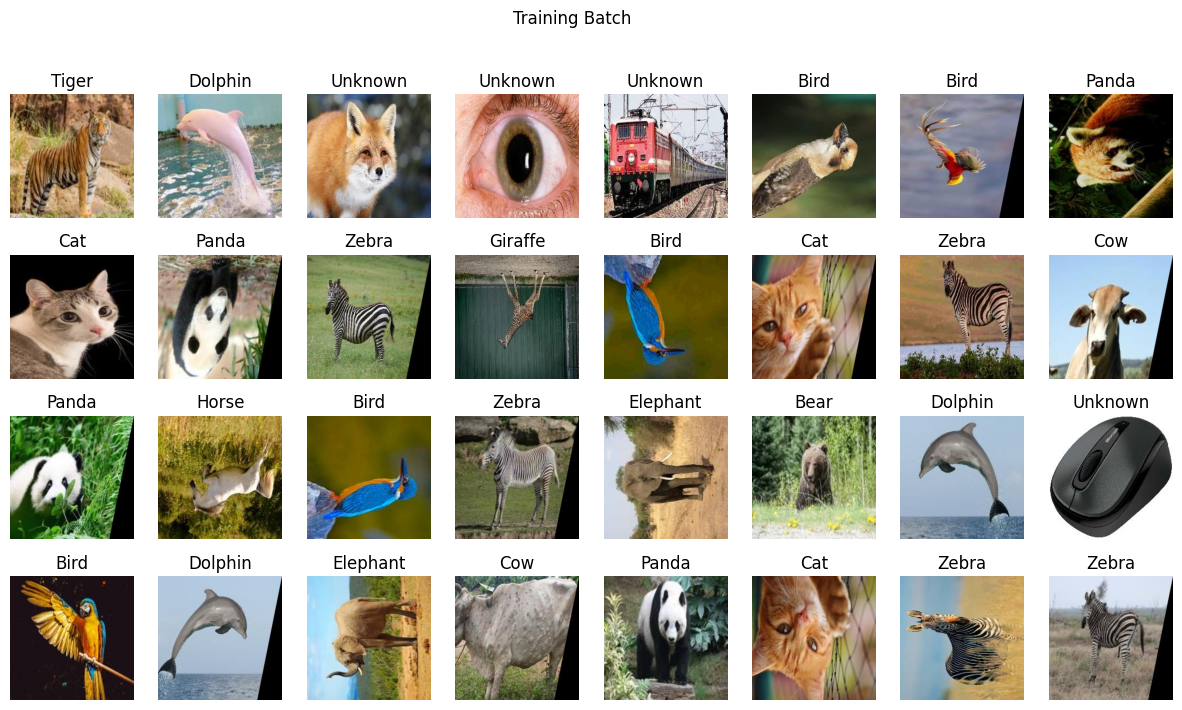

In [8]:
show_batch(train_loader, title="Training Batch")

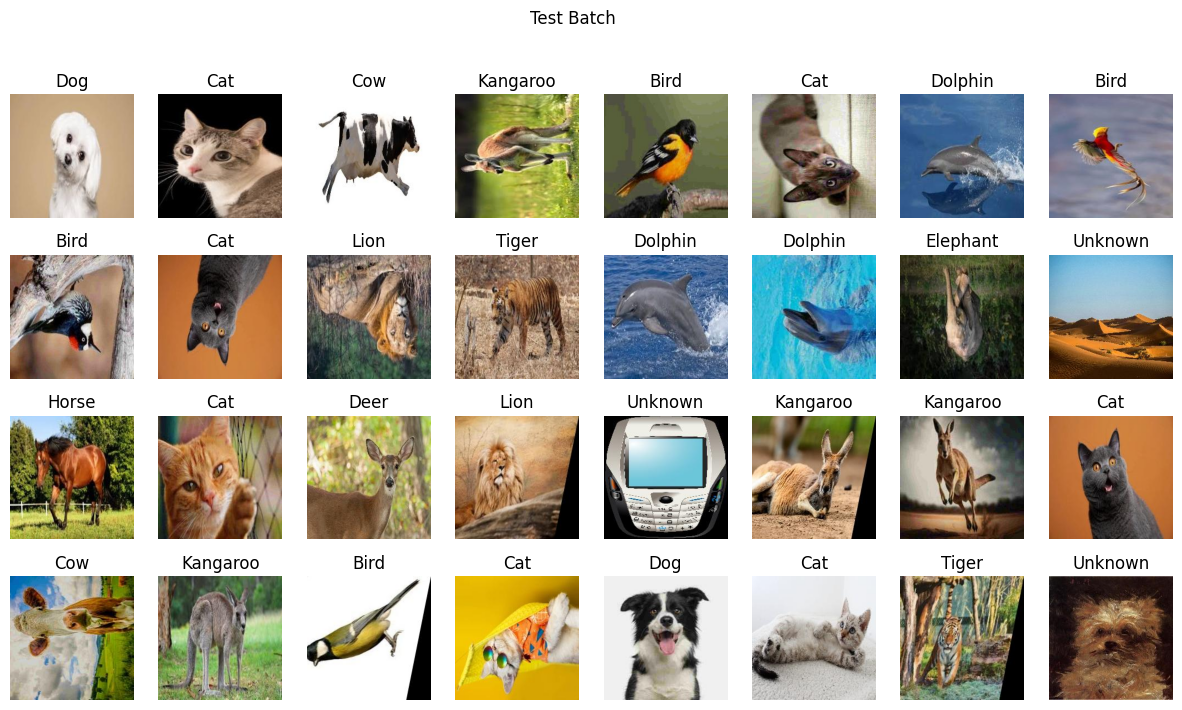

In [9]:
show_batch(test_loader, title="Test Batch")

In [10]:
from torch import nn, optim
from torchvision.models import resnet50, ResNet50_Weights

model=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 16)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model=model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s] 


In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
for _, labels in train_loader:
    print(labels.max())
    break

tensor(15)


In [13]:
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())
print(set(all_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


In [14]:
from tqdm import tqdm
import torch

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # ---------- Training ----------
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.inference_mode():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.78it/s]


Epoch [1/10] Train Loss: 0.5465, Train Acc: 85.19% | Val Loss: 0.3794, Val Acc: 88.43%


Epoch 2/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.69it/s]


Epoch [2/10] Train Loss: 0.1315, Train Acc: 95.85% | Val Loss: 0.2427, Val Acc: 91.85%


Epoch 3/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.57it/s]


Epoch [3/10] Train Loss: 0.0982, Train Acc: 97.02% | Val Loss: 0.0726, Val Acc: 97.84%


Epoch 4/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.44it/s]


Epoch [4/10] Train Loss: 0.0743, Train Acc: 97.75% | Val Loss: 0.4202, Val Acc: 88.91%


Epoch 5/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.44it/s]


Epoch [5/10] Train Loss: 0.0754, Train Acc: 97.72% | Val Loss: 0.1395, Val Acc: 96.52%


Epoch 6/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.41it/s]


Epoch [6/10] Train Loss: 0.0489, Train Acc: 98.67% | Val Loss: 0.1369, Val Acc: 95.80%


Epoch 7/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.46it/s]


Epoch [7/10] Train Loss: 0.0546, Train Acc: 98.49% | Val Loss: 0.3954, Val Acc: 87.77%


Epoch 8/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.39it/s]


Epoch [8/10] Train Loss: 0.0484, Train Acc: 98.65% | Val Loss: 0.0367, Val Acc: 99.04%


Epoch 9/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.44it/s]


Epoch [9/10] Train Loss: 0.0328, Train Acc: 98.95% | Val Loss: 0.0213, Val Acc: 99.22%


Epoch 10/10 [Val]: 100%|██████████| 53/53 [00:06<00:00,  8.35it/s]

Epoch [10/10] Train Loss: 0.0112, Train Acc: 99.73% | Val Loss: 0.0250, Val Acc: 99.16%


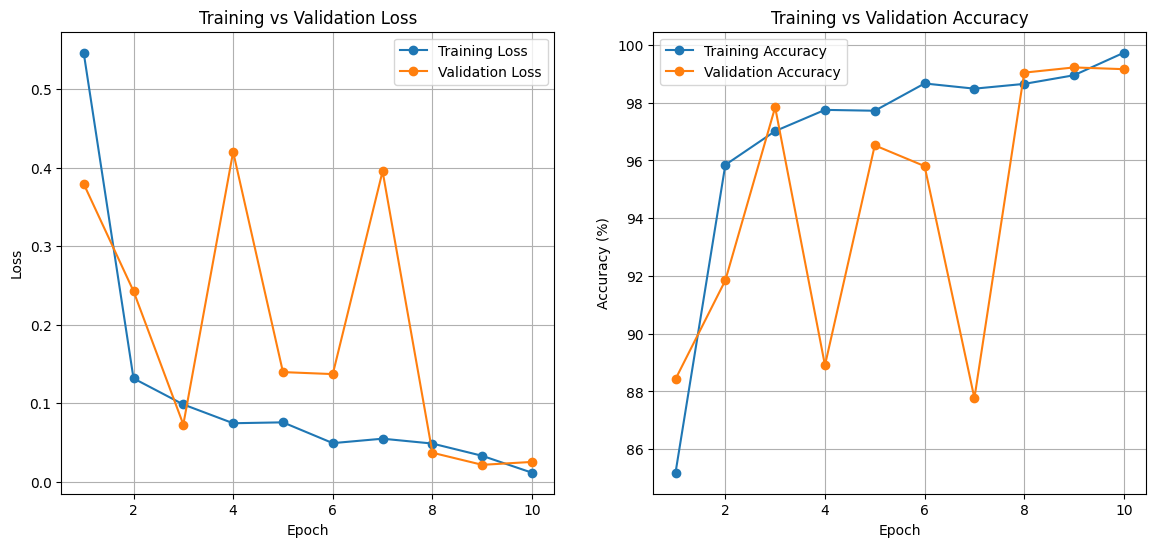

In [15]:
# ---------- Plot Curves ----------
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.show()

<Figure size 1000x800 with 0 Axes>

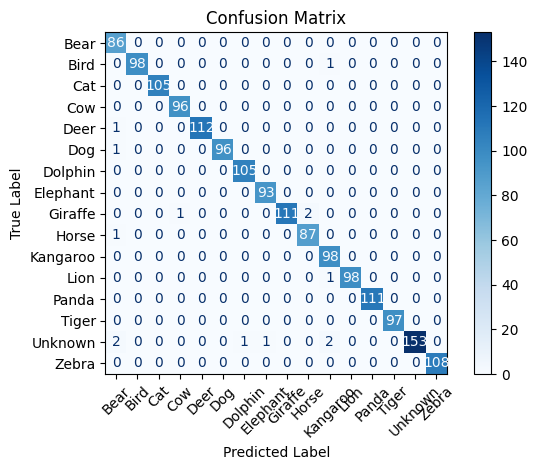

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Define class names
class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer',  'Dog', 'Dolphin', 'Elephant', 
               'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Unknown', 'Zebra']

# Accumulate all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import classification_report

# Generate the report
report = classification_report(all_labels, all_preds, target_names=dataset.classes, digits=4)
print("📊 Classification Report:\n")
print(report)

📊 Classification Report:

              precision    recall  f1-score   support

        Bear     0.9451    1.0000    0.9718        86
        Bird     1.0000    0.9899    0.9949        99
         Cat     1.0000    1.0000    1.0000       105
         Cow     0.9897    1.0000    0.9948        96
        Deer     1.0000    0.9912    0.9956       113
         Dog     1.0000    0.9897    0.9948        97
     Dolphin     0.9906    1.0000    0.9953       105
    Elephant     0.9894    1.0000    0.9947        93
     Giraffe     1.0000    0.9737    0.9867       114
       Horse     0.9775    0.9886    0.9831        88
    Kangaroo     0.9608    1.0000    0.9800        98
        Lion     1.0000    0.9899    0.9949        99
       Panda     1.0000    1.0000    1.0000       111
       Tiger     1.0000    1.0000    1.0000        97
     Unknown     1.0000    0.9623    0.9808       159
       Zebra     1.0000    1.0000    1.0000       108

    accuracy                         0.9916      1668


In [18]:
from sklearn.metrics import f1_score

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.inference_mode():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
f1 = f1_score(all_labels, all_preds, average='macro')  # or 'macro'

print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
      f"Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

100%|██████████| 53/53 [00:05<00:00,  8.87it/s]

Epoch [10/10], Loss: 0.0112, Accuracy: 99.16%, F1 Score: 0.9917


In [19]:
type(model)

torchvision.models.resnet.ResNet

In [20]:
torch.save(model.state_dict(), "resnet50_animal_classifier.pth")

In [22]:
import torch
from torch import nn
#from torchvision.models import resnet50, ResNet50_Weights

# Choose device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model (same architecture as used in training)
#model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#num_features = model.fc.in_features
#model.fc = nn.Linear(num_features, 16)  # 16 = your dataset class count

# Load trained weights (assuming you saved it before)
model.load_state_dict(torch.load('/kaggle/working/resnet50_animal_classifier.pth',
                                 map_location=device))

# Move to GPU or CPU
model = model.to(device)

# Print model summary (like model.summary() in Keras)
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [24]:
import torch
from torch import nn

# Make sure you're using the same device as training
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set model to evaluation mode
model.eval()

criterion = nn.CrossEntropyLoss()
test_loss = 0.0
correct = 0
total = 0

# Turn off gradient calculation for faster evaluation
with torch.no_grad():
    for images, labels in test_loader:  # use your test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"✅ Test Loss: {avg_test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")

✅ Test Loss: 0.0549
✅ Test Accuracy: 98.26%


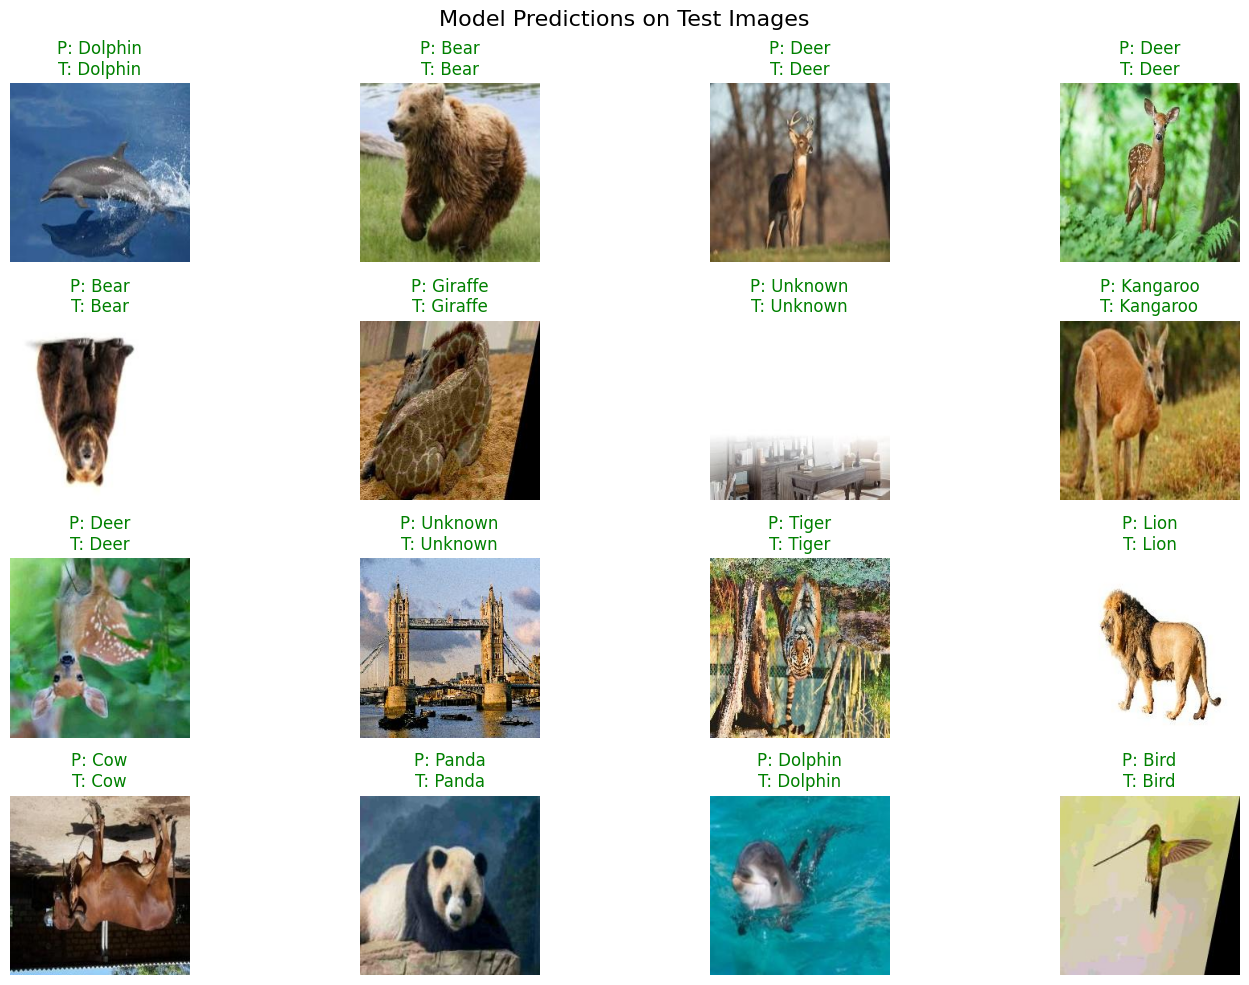

In [26]:
import matplotlib.pyplot as plt
import torch

def show_images(model, data_loader, device, class_names, num_images=16):
    """
    Show model predictions for a batch of images.
    Works for PyTorch models.
    """
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Plot images with true & predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        img = images[i].cpu().permute(1, 2, 0)
        plt.imshow(img)
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        color = "green" if true_label == pred_label else "red"
        ax.set_title(f"P: {pred_label}\nT: {true_label}", color=color)
        ax.axis("off")
    plt.suptitle("Model Predictions on Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()


# ✅ Example usage
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

show_images(
    model=model,
    data_loader=test_loader,   # not test_ds
    device=device,
    class_names=dataset.classes,  # same as your dataset class names
    num_images=16
)

In [27]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms

# Load model
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = models.resnet18(weights=None)
#model.fc = torch.nn.Linear(model.fc.in_features, 15)  # if you have 15 classes
#model.load_state_dict(torch.load("best_model.pth", map_location=device))
#model.to(device)
#model.eval()

# Transform test image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image = Image.open("/kaggle/working/stable_augmented/Unknown/Unknown_289.jpg")  # try any image from your dataset
img = transform(image).unsqueeze(0).to(device)

with torch.inference_mode():
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)
    print("Predicted class index:", predicted.item())


Predicted class index: 14
